# Celeba

Our task is to determine whether the celebrity in the image is smiling. This can be easily changed to any of the binary attributes provided by the original CelebA project by modifying the `TARGET_NAME` constant in `preprocess/metadata_to_json`. We have ignored all celebrities with less than 5 images in our pipeline.

```shell
TARGET_NAME=[
  5_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs,
  Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows,
  Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones,
  Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin,
  Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair,
  Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace,
  Wearing_Necktie, Young]
```

## Data Download

### Setup Instructions

#### Install dependencies

In [2]:
!pip3 install numpy pillow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### Manually Download

In [5]:
!cd ../benchmark/datasets/celeba && mkdir -pv data/raw

- From <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>, download or request the metadata files ```identity_CelebA.txt``` and ```list_attr_celeba.txt```, place them inside the ```data/raw``` folder.
- Download the celebrity faces dataset from the same site. Place the images in a folder named ```img_align_celeba``` in the same folder as above.

#### Generate federated dataset

Run `bash preprocess.sh` with a choice of the following tags:
- `-s` := 'iid' to sample in an i.i.d. manner, or 'niid' to sample in a non-i.i.d. manner; more information on i.i.d. versus non-i.i.d. is included in the 'Notes' section
- `--iu` := number of users, if iid sampling; expressed as a fraction of the total number of users; default is 0.01
- `--sf` := fraction of data to sample, written as a decimal; default is 0.1
- `-k` := minimum number of samples per user
- `-t` := 'user' to partition users into train-test groups, or 'sample' to partition each user's samples into train-test groups
- `--tf` := fraction of data in training set, written as a decimal; default is 0.9
- `--smplseed` := seed to be used before random sampling of data
- `--spltseed` := seed to be used before random split of data

**Small-sized Dataset** (Optional)

In [12]:
# Clear tmp folder
!cd ../benchmark/datasets/celeba/ && rm -rf data/rem_user_data data/sampled_data data/test data/train

# Download data and sampling
!cd ../benchmark/datasets/celeba/ && bash preprocess.sh -s niid --sf 0.05 -k 0 -t sample

./preprocess.sh: line 153: realpath: command not found
------------------------------
sampling data
Using seed 1632618330

- random seed written out to sampling_seed.txt
writing all_data_niid_05.json
------------------------------
removing users with less than 0 samples
writing all_data_niid_05_keep_0.json
------------------------------
generating training and test sets
- random seed written out to split_seed.txt
splitting data by sample
writing all_data_niid_05_keep_0_train_9.json
writing all_data_niid_05_keep_0_test_9.json
------------------------------
calculating JSON file checksums
checksums written to meta/dir-checksum.md5


**Full-sized Dataset** (Optional)

In [ ]:
# Clear tmp folder
!cd ../benchmark/datasets/celeba/ && rm -rf data/rem_user_data data/sampled_data data/test data/train

# Download data and sampling
!cd ../benchmark/datasets/celeba/ && bash preprocess.sh -s niid --sf 1.0 -k 0 -t sample

### Notes

- More details on i.i.d. versus non-i.i.d.:
  - In the i.i.d. sampling scenario, each data-point is equally likely to be sampled. Thus, all users have the same underlying distribution of data.
  - In the non-i.i.d. sampling scenario, the underlying distribution of data for each user is consistent with the raw data. Since we assume that data distributions vary between user in the raw data, we refer to this sampling process as non-i.i.d.
- More details on `preprocess.sh`:
  - The order in which `preprocess.sh` processes data is 1. generating all_data, 2. sampling, 3. removing users, and 4. creating train-test split. The script will look at the data in the last generated directory and continue preprocessing from that point. For example, if the `all_data` directory has already been generated and the user decides to skip sampling and only remove users with the `-k` tag (i.e. running `preprocess.sh -k 50`), the script will effectively apply a remove user filter to data in `all_data` and place the resulting data in the `rem_user_data` directory.
  - File names provide information about the preprocessing steps taken to generate them. For example, the `all_data_niid_1_keep_64.json` file was generated by first sampling 10 percent (.1) of the data `all_data.json` in a non-i.i.d. manner and then applying the `-k 64` argument to the resulting data.
- Each .json file is an object with 3 keys:
  1. 'users', a list of users
  2. 'num_samples', a list of the number of samples for each user, and
  3. 'user_data', an object with user names as keys and their respective data as values.
- Run `./stats.sh` to get statistics of data (`data/all_data/all_data.json` must have been generated already)
- In order to run reference implementations in `../models` directory, the `-t sample` tag must be used when running `./preprocess.sh`

### Valid dataset

In [14]:
from benchmark.datasets.celeba import get_celeba
dataset = get_celeba('../benchmark/datasets/celeba/data')
print(dataset)
x, y = dataset[0]
print(x.shape, y.shape)

SimulationDataset(total_parts: 468, total_samples: 8870, current_parts: 0)
torch.Size([3, 84, 84]) torch.Size([])


## FedAvg, FedSGD, FedEla, FedProx, FedScaffold

Run following commands in the root path of `benchmark-lightly`.


```bash
function cmd(){
    fed_optim=$1
    
    task_name="celeba"
    exp_name=${fed_optim}_${task_name}

    # Delete cache file
    rm -rf /tmp/${exp_name}.share
    rm -rf /tmp/${exp_name}
    rm -rf ./logs/${task_name}/${fed_optim}

    # Run
    python -m openfed.tools.launch --nproc_per_node 6  --logdir /tmp benchmark/run.py\
        --fed_init_method file:///tmp/${exp_name}.share\
        --task ${task_name}\
        --data_root benchmark/datasets/${task_name}/data\
        --epochs 1\
        --rounds 200\
        --act_clts 100\
        --tst_act_clts 100\
        --max_acg_step -1\
        --optim ${fed_optim}\
        --optim_args momentum:0.9 weight_decay:1e-4\
        --follower_lr 0.01\
        --leader_lr 1.0\
        --bz 100\
        --gpu\
        --log_level SUCCESS\
        --log_dir logs\
        --exp_name ${exp_name}\
        --seed 0
}
```

### Run All

```bash
cmd 'fedavg'; cmd 'fedsgd'; cmd 'fedela'; cmd 'fedprox'; cmd 'fedscaffold'
```

## Plot Curves

In [1]:
%matplotlib inline

from benchmark.utils.plot import plot

task_name = "celeba"

items = dict(
    FedAvg=f'../logs/{task_name}/fedavg_{task_name}/{task_name}.json',
    FedSgd=f'../logs/{task_name}/fedsgd_{task_name}/{task_name}.json',
    FedEla=f'../logs/{task_name}/fedela_{task_name}/{task_name}.json',
    FedProx=f'../logs/{task_name}/fedprox_{task_name}/{task_name}.json',
    FedScaffold=f'../logs/{task_name}/fedscaffold_{task_name}/{task_name}.json',
)

files = items.values()
labels = items.keys()

### Train Accuracy

/Users/densechen/miniconda3/envs/openfed/lib/python3.7/site-packages/benchmark-0.0.0-py3.7.egg/benchmark/utils/plot.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs, ys = np.array(xs), np.array(ys)


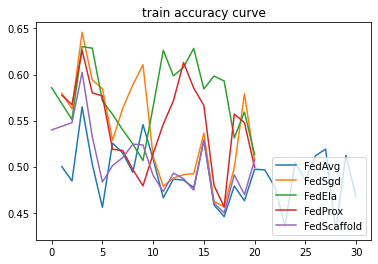

In [2]:
plot(
    files=files,
    labels=labels,
    attributes="accuracy",
    mode='train'
)

### Train Loss

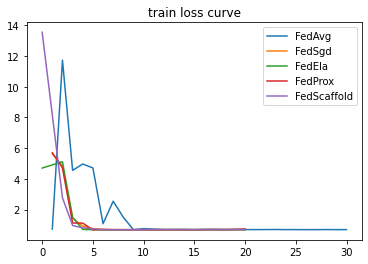

In [3]:
plot(
    files=files,
    labels=labels,
    attributes="loss",
    mode="train"
)

### Test Accuracy

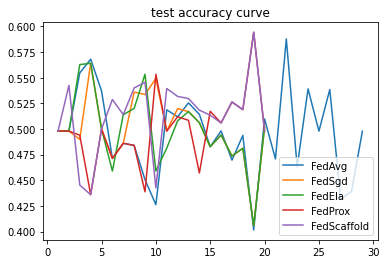

In [4]:
plot(
    files=files,
    labels=labels,
    attributes="accuracy",
    mode="test"
)

### Test Loss

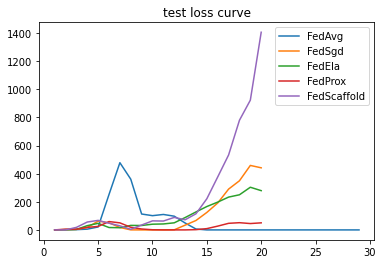

In [5]:
plot(
    files=files,
    labels=labels,
    attributes="loss",
    mode='test'
)